# Stock Price prediction with RNN

In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

import yfinance as yf

### Getting data and clean it up

In [2]:
Stock = 'SPY'
data = yf.download(Stock, period="5y")

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300


In [3]:
data = data.asfreq('D')

In [4]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700.0
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500.0
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000.0
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-20,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-21,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300.0
2016-02-23,194.000000,194.320007,192.179993,192.320007,174.614578,111455300.0
2016-02-24,190.630005,193.529999,189.320007,193.199997,175.413559,150812200.0


In [5]:
data = data.ffill()

In [6]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-16,188.770004,189.809998,187.630005,189.779999,172.308426,120250700.0
2016-02-17,191.160004,193.320007,191.009995,192.880005,175.123047,136009500.0
2016-02-18,193.199997,193.270004,191.720001,192.089996,174.405762,102343000.0
2016-02-19,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-20,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-21,191.169998,192.179993,190.449997,192.000000,174.324066,114793000.0
2016-02-22,193.869995,194.949997,193.789993,194.779999,176.848099,103640300.0
2016-02-23,194.000000,194.320007,192.179993,192.320007,174.614578,111455300.0
2016-02-24,190.630005,193.529999,189.320007,193.199997,175.413559,150812200.0


In [7]:
data.index

DatetimeIndex(['2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19',
               '2016-02-20', '2016-02-21', '2016-02-22', '2016-02-23',
               '2016-02-24', '2016-02-25',
               ...
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06',
               '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10',
               '2021-02-11', '2021-02-12'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

### Split the data into train/test sets

In [8]:
len(data)

1824

In [9]:
1824-7*26

1642

In [10]:
# Set one year for testing
train = data.iloc[:1642][['Close']]
test = data.iloc[1642:][['Close']]

In [11]:
train.head()

,Close
Date,
2016-02-16,189.779999
2016-02-17,192.880005
2016-02-18,192.089996
2016-02-19,192.000000
2016-02-20,192.000000


In [12]:
test.head()

,Close
Date,
2020-08-15,336.839996
2020-08-16,336.839996
2020-08-17,337.910004
2020-08-18,338.640015
2020-08-19,337.230011


### Scale Data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
scaled_train

array([[0.        ],
       [0.02086703],
       [0.01554926],
       ...,
       [0.99394188],
       [0.98983569],
       [0.98990307]])

In [19]:
# Making a generator which uses the past 8 weeks
n_input = 7*8
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
# What does the first batch look like?
X,y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02086703 0.01554926 0.01494347 0.01494347 0.01494347
 0.03365644 0.01709753 0.02302099 0.03877218 0.03574312 0.03574312
 0.03574312 0.02544426 0.05607163 0.06206248 0.06731287 0.07168817
 0.07168817 0.07168817 0.0727652  0.05802366 0.0646204  0.06569733
 0.08737208 0.08737208 0.08737208 0.08562198 0.08340064 0.09127624
 0.09995966 0.09827683 0.09827683 0.09827683 0.10022886 0.09948842
 0.09040124 0.08979535 0.08979535 0.08979535 0.08979535 0.09060317
 0.10325792 0.10931614 0.1059505  0.11537426 0.11537426 0.11537426
 0.11086431 0.09699787 0.11200861 0.09538233 0.09908455 0.09908455
 0.09908455 0.09585357]
Predict this y: 
 [[0.10864297]]


### Create the Model

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# define model
n_features = 1

model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
#model.fit_generator(generator,epochs=2)
model.fit(generator,epochs=10)

Epoch 1/10
1586/1586 [==============================] - 13s 8ms/step - loss: 0.0330
Epoch 2/10
1586/1586 [==============================] - 13s 8ms/step - loss: 9.2338e-04
Epoch 3/10
1586/1586 [==============================] - 16s 10ms/step - loss: 6.0100e-04
Epoch 4/10
1586/1586 [==============================] - 15s 9ms/step - loss: 6.1062e-04
Epoch 5/10
1586/1586 [==============================] - 16s 10ms/step - loss: 4.9031e-04
Epoch 6/10
1586/1586 [==============================] - 15s 9ms/step - loss: 4.5670e-04
Epoch 7/10
1586/1586 [==============================] - 15s 10ms/step - loss: 4.4021e-04
Epoch 8/10
1586/1586 [==============================] - 15s 10ms/step - loss: 4.0400e-04
Epoch 9/10
1586/1586 [==============================] - 16s 10ms/step - loss: 3.8703e-04
Epoch 10/10
1586/1586 [==============================] - 15s 10ms/step - loss: 4.3543e-04


In [28]:
model.history.history.keys()

dict_keys(['loss'])

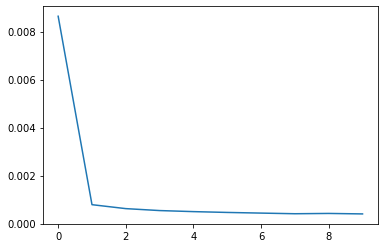

In [29]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Evaluate on Test Data

In [30]:
first_eval_batch = scaled_train[-7*8:]

In [31]:
first_eval_batch

array([[0.8000809 ],
       [0.8000809 ],
       [0.81340871],
       [0.8230344 ],
       [0.76945342],
       [0.79139748],
       [0.74225896],
       [0.74225896],
       [0.74225896],
       [0.77194396],
       [0.79819594],
       [0.81273554],
       [0.82424619],
       [0.82424619],
       [0.82424619],
       [0.82424619],
       [0.85669084],
       [0.8346796 ],
       [0.85083465],
       [0.83871842],
       [0.86032579],
       [0.86032579],
       [0.86032579],
       [0.84181475],
       [0.86927852],
       [0.88900114],
       [0.88186599],
       [0.88812604],
       [0.88812604],
       [0.88812604],
       [0.90562743],
       [0.91027203],
       [0.92272475],
       [0.89647277],
       [0.88247178],
       [0.88247178],
       [0.88247178],
       [0.89822297],
       [0.88442391],
       [0.91101238],
       [0.90320406],
       [0.92043614],
       [0.92043614],
       [0.92043614],
       [0.93571629],
       [0.94426495],
       [0.95806401],
       [0.973

In [32]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [33]:
model.predict(first_eval_batch)

array([[0.9755546]], dtype=float32)

In [34]:
scaled_test[0]

array([0.98990307])

put this logic in a for loop to predict into the future for the entire test range.

In [35]:
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [36]:
current_batch.shape

(1, 56, 1)

In [37]:
current_batch

array([[[0.8000809 ],
        [0.8000809 ],
        [0.81340871],
        [0.8230344 ],
        [0.76945342],
        [0.79139748],
        [0.74225896],
        [0.74225896],
        [0.74225896],
        [0.77194396],
        [0.79819594],
        [0.81273554],
        [0.82424619],
        [0.82424619],
        [0.82424619],
        [0.82424619],
        [0.85669084],
        [0.8346796 ],
        [0.85083465],
        [0.83871842],
        [0.86032579],
        [0.86032579],
        [0.86032579],
        [0.84181475],
        [0.86927852],
        [0.88900114],
        [0.88186599],
        [0.88812604],
        [0.88812604],
        [0.88812604],
        [0.90562743],
        [0.91027203],
        [0.92272475],
        [0.89647277],
        [0.88247178],
        [0.88247178],
        [0.88247178],
        [0.89822297],
        [0.88442391],
        [0.91101238],
        [0.90320406],
        [0.92043614],
        [0.92043614],
        [0.92043614],
        [0.93571629],
        [0

In [38]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
test_predictions

[array([0.9755546], dtype=float32),
 array([0.96150804], dtype=float32),
 array([0.9450506], dtype=float32),
 array([0.9273195], dtype=float32),
 array([0.90831494], dtype=float32),
 array([0.888156], dtype=float32),
 array([0.86698836], dtype=float32),
 array([0.8449597], dtype=float32),
 array([0.8222131], dtype=float32),
 array([0.7988867], dtype=float32),
 array([0.7751141], dtype=float32),
 array([0.7510245], dtype=float32),
 array([0.7267416], dtype=float32),
 array([0.7023837], dtype=float32),
 array([0.6780617], dtype=float32),
 array([0.6538791], dtype=float32),
 array([0.62992996], dtype=float32),
 array([0.60629857], dtype=float32),
 array([0.5830588], dtype=float32),
 array([0.5602738], dtype=float32),
 array([0.5379958], dtype=float32),
 array([0.51626647], dtype=float32),
 array([0.4951174], dtype=float32),
 array([0.47457048], dtype=float32),
 array([0.45463893], dtype=float32),
 array([0.4353284], dtype=float32),
 array([0.41663727], dtype=float32),
 array([0.39855802],

In [40]:
scaled_test

array([[0.98990307],
       [0.98990307],
       [0.9971056 ],
       [1.00201951],
       [0.99252837],
       [0.99959614],
       [1.00767377],
       [1.00767377],
       [1.00767377],
       [1.03082941],
       [1.03890683],
       [1.06212985],
       [1.06724549],
       [1.08239089],
       [1.08239089],
       [1.08239089],
       [1.07384223],
       [1.09598822],
       [1.13031783],
       [1.0474557 ],
       [1.02847342],
       [1.02847342],
       [1.02847342],
       [1.02847342],
       [0.96546846],
       [1.00976045],
       [0.9700459 ],
       [0.9711901 ],
       [0.9711901 ],
       [0.9711901 ],
       [1.00080772],
       [1.01231837],
       [1.00323109],
       [0.98317178],
       [0.94823639],
       [0.94823639],
       [0.94823639],
       [0.9234653 ],
       [0.94588039],
       [0.89431892],
       [0.90010772],
       [0.93531243],
       [0.93531243],
       [0.93531243],
       [0.9720652 ],
       [0.95981421],
       [0.97677718],
       [0.991

### Inverse Transformations and Compare

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

In [42]:
true_predictions

array([[334.70838561],
       [332.62163021],
       [330.17671319],
       [327.5425854 ],
       [324.71926454],
       [321.7244515 ],
       [318.57978756],
       [315.30720622],
       [311.92797688],
       [308.46260741],
       [304.93095041],
       [301.35219438],
       [297.74473088],
       [294.1261191 ],
       [290.5128468 ],
       [286.92027718],
       [283.36239207],
       [279.85171224],
       [276.39920889],
       [273.01427702],
       [269.70465578],
       [266.47654359],
       [263.33463794],
       [260.28218857],
       [257.32115684],
       [254.45238396],
       [251.67563084],
       [248.98977735],
       [246.3929551 ],
       [243.88268475],
       [241.4559999 ],
       [239.1095667 ],
       [236.83975022],
       [234.64278716],
       [232.51474594],
       [230.45169501],
       [228.44973381],
       [226.50497946],
       [224.61367308],
       [222.77217976],
       [220.97699738],
       [219.22476552],
       [217.51231415],
       [215

In [43]:
test

,Close
Date,
2020-08-15,336.839996
2020-08-16,336.839996
2020-08-17,337.910004
2020-08-18,338.640015
2020-08-19,337.230011
...,...
2021-02-08,390.510010
2021-02-09,390.250000
2021-02-10,390.079987


In [44]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [45]:
test

,Close,Predictions
Date,,
2020-08-15,336.839996,334.708386
2020-08-16,336.839996,332.621630
2020-08-17,337.910004,330.176713
2020-08-18,338.640015,327.542585
2020-08-19,337.230011,324.719265
...,...,...
2021-02-08,390.510010,189.200526
2021-02-09,390.250000,189.200192
2021-02-10,390.079987,189.199869


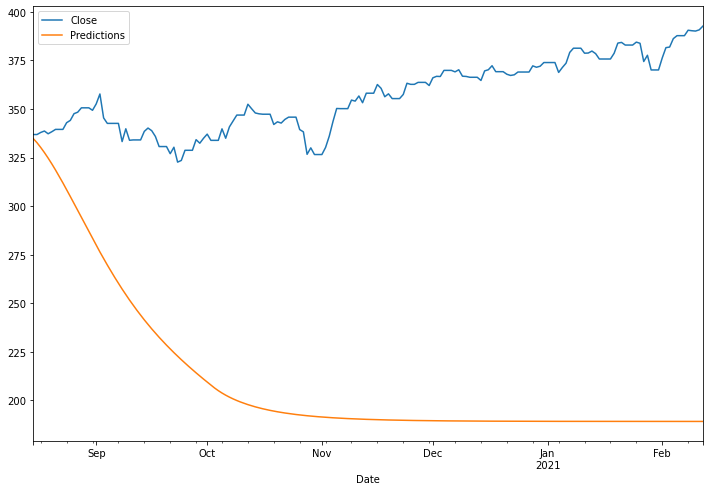

In [46]:
test.plot(figsize=(12,8))

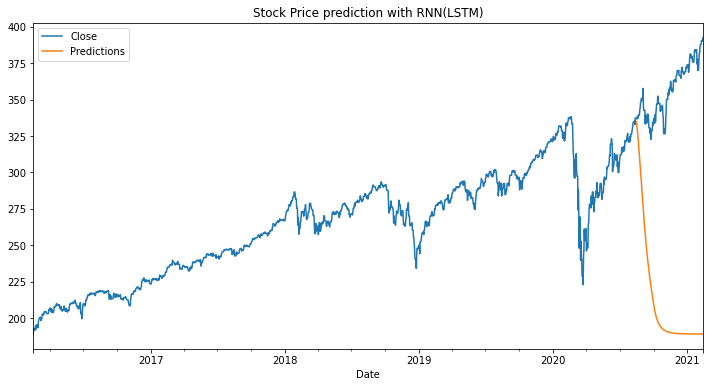

In [50]:
# Plot predictions against known values
title = 'Stock Price prediction with RNN(LSTM)'

ax = data['Close'].plot(legend=True,figsize=(12,6),title=title)
test['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Saving and Loading Models

In [47]:
model.save('my_rnn_model.h5')

In [48]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [49]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
